In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import csv
import numpy as np

# Read runtimes from logfiles

In [3]:
def read_logfile(logfile):
    runtimes_dict = []
    header = None
    with open(logfile, 'r') as f:
        for line in csv.reader(f, delimiter='\t'):
            if header is None:
                header = line
            else:
                runtime_dict = {}
                for (header_elem, line_elem) in zip(header, line):
                    if header_elem != 'scenario':
                        if line_elem == '':
                            runtime_dict[header_elem] = None
                        else:
                            runtime_dict[header_elem] = float(line_elem)
                    else:
                        runtime_dict[header_elem] = line_elem
                runtimes_dict.append(runtime_dict)
    return runtimes_dict

In [4]:
runtimes_dict = read_logfile("inference_runtimes.tsv")

# Plot runtimes versus idealized runtimes for various models

In [16]:
def plot_runtime_versus_idealized_runtime(runtimes_dict, label,
                                          filter_fn=None,
                                          output_filename=None):
    print(label)
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    for runtime_dict in runtimes_dict:
        if filter_fn is None or filter_fn(runtime_dict):
            ax.scatter(runtime_dict["inference_runtime"],
                       runtime_dict["inference_idealized_runtime"],
                       marker='o', color='black')
    ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')

    # ax.set_xlim(0.1, 100)
    # ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Runtime (seconds)")
    ax.set_ylabel("Idealized runtime\n(seconds)")
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    plt.show()

All


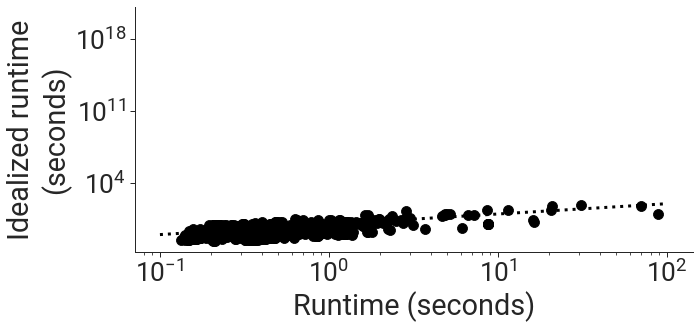

In [17]:
plot_runtime_versus_idealized_runtime(runtimes_dict, "All")

OpenAI/davinci


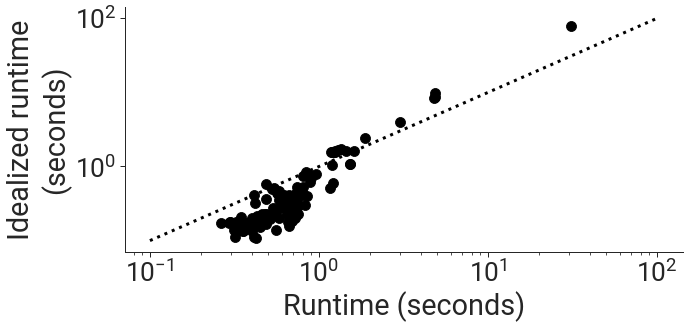

OpenAI/text-davinci-001


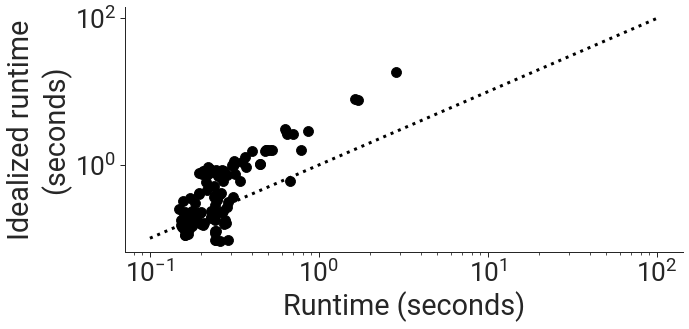

AI21/j1-jumbo


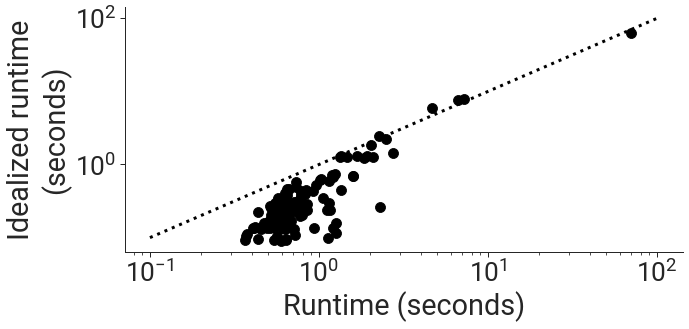

Anthropic


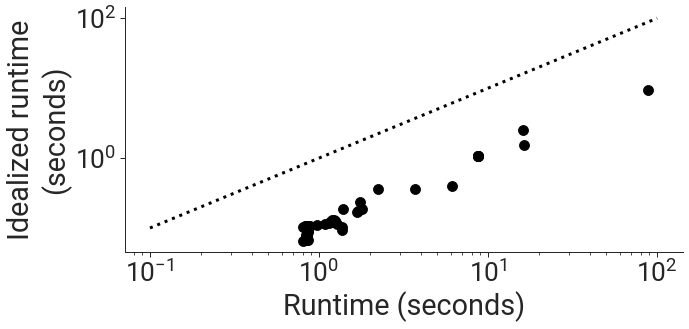

MT-Turing-NLG


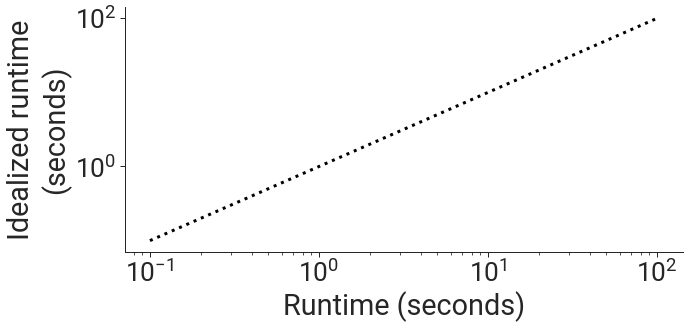

In [18]:
def filter_fn(runtime_dict, model):
    scenario = runtime_dict["scenario"]
    if model in scenario:
        return True
    return False

plot_runtime_versus_idealized_runtime(runtimes_dict, "OpenAI/davinci",
                                      lambda x: filter_fn(x, "openai_davinci"),
                                      output_filename="figures/runtime_vs_idealized_runtime/openai_davinci.pdf")
plot_runtime_versus_idealized_runtime(runtimes_dict, "OpenAI/text-davinci-001",
                                      lambda x: filter_fn(x, "openai_text-davinci-001"),
                                      output_filename="figures/runtime_vs_idealized_runtime/openai_text_davinci_001.pdf")
plot_runtime_versus_idealized_runtime(runtimes_dict, "AI21/j1-jumbo",
                                      lambda x: filter_fn(x, "ai21_j1-jumbo"),
                                      output_filename="figures/runtime_vs_idealized_runtime/ai21_j1_jumbo.pdf")
plot_runtime_versus_idealized_runtime(runtimes_dict, "Anthropic",
                                      lambda x: filter_fn(x, "anthropic_stanford-online-helpful-v4-s3"),
                                      output_filename="figures/runtime_vs_idealized_runtime/anthropic.pdf")
plot_runtime_versus_idealized_runtime(runtimes_dict, "MT-Turing-NLG",
                                      lambda x: filter_fn(x, "microsoft_TNLGv2_530B"),
                                      output_filename="figures/runtime_vs_idealized_runtime/mt_nlg.pdf")

# Compare runtimes for various models

In [8]:
def plot_metrics_for_various_models(metrics_dict, metric_name,
                                    model1, model2,
                                    model1_label, model2_label,
                                    metric_label,
                                    filter_thresholds=None):
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    metrics_per_scenario = {}
    num_tokens_per_scenario = {}
    for metric_dict in metrics_dict:
        scenario = metric_dict["scenario"]
        for i, model in enumerate([model1, model2]):
            if model in scenario:
                scenario = scenario.split(":")
                arguments = scenario.pop(-1)
                scenario.extend(arguments.split(","))
                scenario.remove("model=%s" % model)
                scenario = ",".join(scenario)
                if scenario not in metrics_per_scenario:
                    metrics_per_scenario[scenario] = {}
                    num_tokens_per_scenario[scenario] = {}
                metrics_per_scenario[scenario][f"model{i}"] = metric_dict[metric_name]
                num_tokens_per_scenario[scenario][f"model{i}"] = metric_dict["num_tokens"]

    def filter_function_within_threshold(metrics_per_scenario, threshold_range):
        num_tokens_in_model0 = metrics_per_scenario["model0"]
        num_tokens_in_model1 = metrics_per_scenario["model1"]
        if num_tokens_in_model0 is None or num_tokens_in_model1 is None:
            return False
        if num_tokens_in_model1 == 0:
            ratio = np.inf
        else:
            ratio = float(num_tokens_in_model0) / num_tokens_in_model1
        if threshold_range[0] < ratio < threshold_range[1]:
            return True
        if threshold_range[0] < (1. / ratio) < threshold_range[1]:
            return True
        return False
                
    colors = ['black', 'red', 'blue', 'green', 'purple']
    if filter_thresholds is None:
        filter_thresholds = [None]
    for filter_threshold, color in zip(filter_thresholds, colors):
        ratios = []
        print(f"Filter threshold = {filter_threshold}, color = {color}")
        for scenario in metrics_per_scenario:
            if filter_threshold is not None:
                if not filter_function_within_threshold(num_tokens_per_scenario[scenario],
                                                        filter_threshold):
                    continue
            ax.scatter(metrics_per_scenario[scenario]["model0"],
                       metrics_per_scenario[scenario]["model1"],
                       marker='o', color=color)
            if metrics_per_scenario[scenario]["model0"] is None or \
                metrics_per_scenario[scenario]["model1"] is None:
                continue
            if metrics_per_scenario[scenario]["model1"] == 0:
                ratios.append(np.inf)
            else:
                ratios.append(metrics_per_scenario[scenario]["model0"] /
                              metrics_per_scenario[scenario]["model1"])
        print(f"Average metric ratio: "
              f"{np.mean([ratio for ratio in ratios if ratio < np.inf]):.2f}")
        print(f"Maximum metric ratio: {np.max(ratios):.2f}")
        print(f"Minimum metric ratio: {np.min(ratios):.2f}")
        print()
    ax.plot([0.1, 100], [0.1, 100], color='black', linestyle=':')
    
    ax.set_xlim(0.1, 100)
    ax.set_ylim(0.1, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f"{model1_label} {metric_label}")
    ax.set_ylabel(f"{model2_label}\n{metric_label}")
    sns.despine()
    plt.show()

Filter threshold = None, color = black
Average metric ratio: 2.69
Maximum metric ratio: 10.87
Minimum metric ratio: 1.57



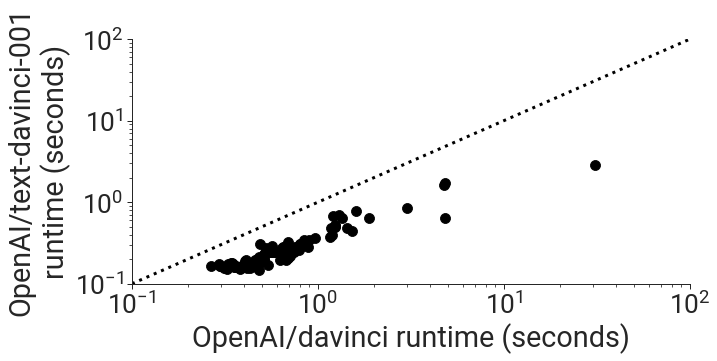

Filter threshold = None, color = black
Average metric ratio: 0.99
Maximum metric ratio: 4.90
Minimum metric ratio: 0.26



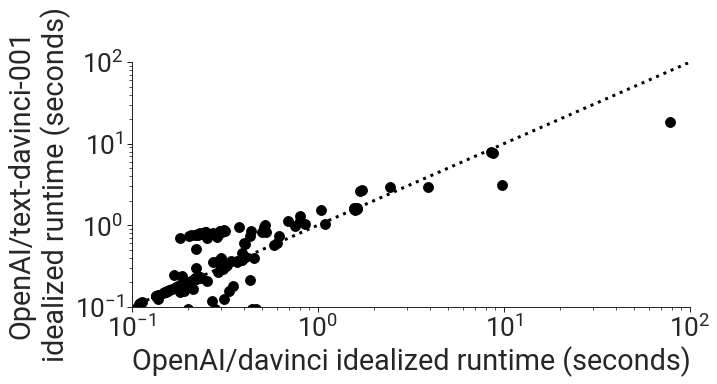

Filter threshold = None, color = black
Average metric ratio: 1.01
Maximum metric ratio: inf
Minimum metric ratio: 0.09



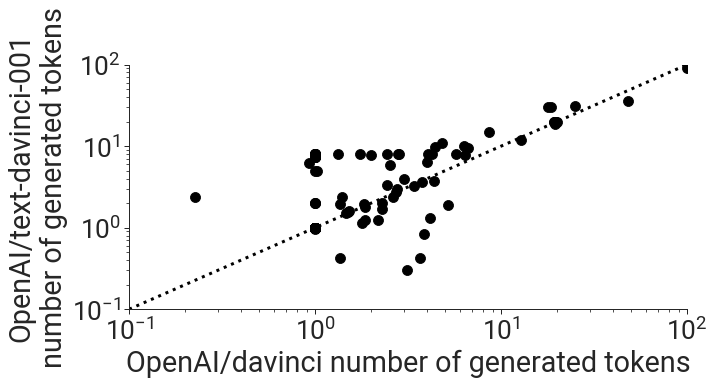

In [9]:
plot_metrics_for_various_models(runtimes_dict, "inference_runtime",
                                "openai_davinci", "openai_text-davinci-001",
                                "OpenAI/davinci", "OpenAI/text-davinci-001",
                                "runtime (seconds)")
plot_metrics_for_various_models(runtimes_dict, "inference_idealized_runtime",
                                "openai_davinci", "openai_text-davinci-001",
                                "OpenAI/davinci", "OpenAI/text-davinci-001",
                                "idealized runtime (seconds)")
plot_metrics_for_various_models(runtimes_dict, "num_tokens",
                                "openai_davinci", "openai_text-davinci-001",
                                "OpenAI/davinci", "OpenAI/text-davinci-001",
                                "number of generated tokens")

Filter threshold = [0.8, 1.0], color = black
Average metric ratio: 2.77
Maximum metric ratio: 3.40
Minimum metric ratio: 1.90

Filter threshold = [0.5, 0.8], color = red
Average metric ratio: 2.75
Maximum metric ratio: 3.52
Minimum metric ratio: 1.85

Filter threshold = [0.25, 0.5], color = blue
Average metric ratio: 3.00
Maximum metric ratio: 7.66
Minimum metric ratio: 2.17

Filter threshold = [0.1, 0.25], color = green
Average metric ratio: 3.24
Maximum metric ratio: 10.87
Minimum metric ratio: 1.92

Filter threshold = [0.0, 0.1], color = purple
Average metric ratio: 2.40
Maximum metric ratio: 2.46
Minimum metric ratio: 2.34



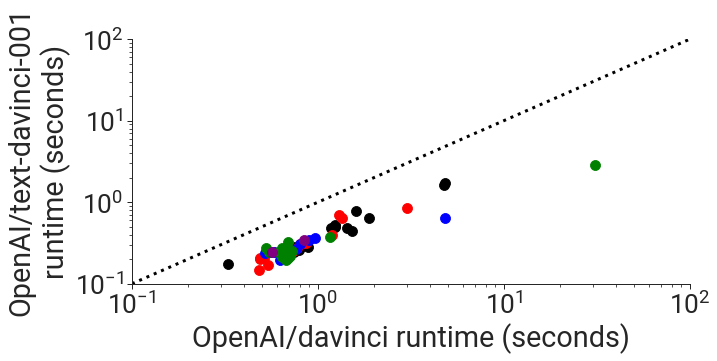

Filter threshold = [0.8, 1.0], color = black
Average metric ratio: 1.01
Maximum metric ratio: 1.14
Minimum metric ratio: 0.84

Filter threshold = [0.5, 0.8], color = red
Average metric ratio: 0.86
Maximum metric ratio: 1.35
Minimum metric ratio: 0.59

Filter threshold = [0.25, 0.5], color = blue
Average metric ratio: 1.03
Maximum metric ratio: 3.12
Minimum metric ratio: 0.36

Filter threshold = [0.1, 0.25], color = green
Average metric ratio: 0.64
Maximum metric ratio: 4.28
Minimum metric ratio: 0.26

Filter threshold = [0.0, 0.1], color = purple
Average metric ratio: 1.49
Maximum metric ratio: 2.32
Minimum metric ratio: 0.67



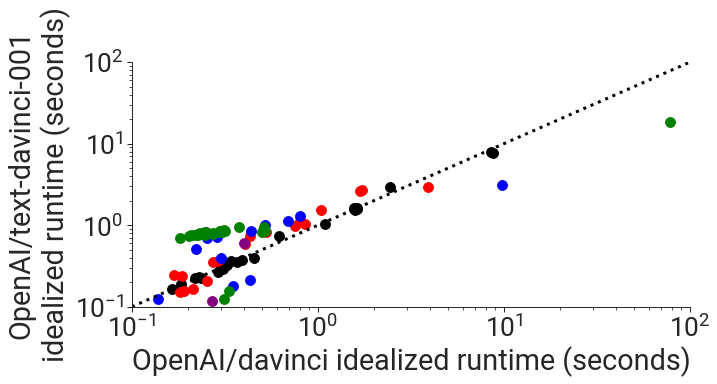

In [10]:
plot_metrics_for_various_models(runtimes_dict, "inference_runtime",
                                "openai_davinci", "openai_text-davinci-001",
                                "OpenAI/davinci", "OpenAI/text-davinci-001",
                                "runtime (seconds)",
                                [[0.8, 1.0], [0.5, 0.8], [0.25, 0.5], [0.1, 0.25], [0.0, 0.1]])
plot_metrics_for_various_models(runtimes_dict, "inference_idealized_runtime",
                                "openai_davinci", "openai_text-davinci-001",
                                "OpenAI/davinci", "OpenAI/text-davinci-001",
                                "idealized runtime (seconds)",
                                [[0.8, 1.0], [0.5, 0.8], [0.25, 0.5], [0.1, 0.25], [0.0, 0.1]])

In [11]:
def plot_metric_cdf(metrics_dict, metric_name,
                    models,
                    model_labels,
                    metric_label):
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    metrics_per_model = {}
    for metric_dict in metrics_dict:
        scenario = metric_dict["scenario"]
        for model in models:
            if model in scenario:
                scenario = scenario.split(":")
                arguments = scenario.pop(-1)
                scenario.extend(arguments.split(","))
                scenario.remove("model=%s" % model)
                scenario = ",".join(scenario)
                if model not in metrics_per_model:
                    metrics_per_model[model] = []
                if metric_dict[metric_name] is not None:
                    metrics_per_model[model].append(metric_dict[metric_name])
                
    for model, model_label in zip(models, model_labels):
        metrics = metrics_per_model[model]
        metrics.sort()
        ax.plot(metrics,
                [(float(i+1) * 100.0) / len(metrics) for i in range(len(metrics))],
                label=model_label)
        
    plt.legend(frameon=False)
    
    ax.set_xlim(0.0, 5)
    ax.set_ylim(0.0, 100.0)
    ax.set_xlabel(f"{metric_label}")
    ax.set_ylabel("Percentile (%)")
    sns.despine()
    plt.show()

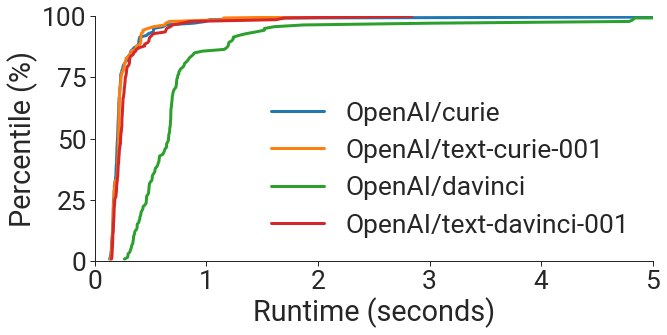

In [12]:
plot_metric_cdf(runtimes_dict, "inference_runtime",
                ["openai_curie", "openai_text-curie-001", "openai_davinci", "openai_text-davinci-001"],
                ["OpenAI/curie", "OpenAI/text-curie-001", "OpenAI/davinci", "OpenAI/text-davinci-001"],
                "Runtime (seconds)")

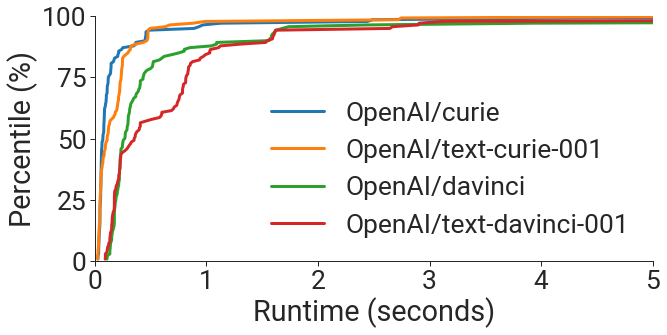

In [13]:
plot_metric_cdf(runtimes_dict, "inference_idealized_runtime",
                ["openai_curie", "openai_text-curie-001", "openai_davinci", "openai_text-davinci-001"],
                ["OpenAI/curie", "OpenAI/text-curie-001", "OpenAI/davinci", "OpenAI/text-davinci-001"],
                "Runtime (seconds)")

# Plot runtimes versus accuracy metrics

In [14]:
def plot_metric1_versus_metric2(metrics_dict, metric1_name,
                                metric2_name,
                                models, scenario_regex,
                                model_labels,
                                metric1_label, metric2_label):
    print(f"Scenario regex: {scenario_regex}")
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    metrics_per_model = {}
    for metric_dict in metrics_dict:
        scenario = metric_dict["scenario"]
        for model in models:
            if model in scenario:
                scenario = scenario.split(":")
                arguments = scenario.pop(-1)
                scenario.extend(arguments.split(","))
                scenario.remove("model=%s" % model)
                scenario = ",".join(scenario)
                if not re.fullmatch(scenario_regex, scenario):
                    continue
                metrics_per_model[model] = (metric_dict[metric1_name],
                                            metric_dict[metric2_name])
                
    for model, model_label in zip(models, model_labels):
        x = metrics_per_model[model][0]
        y = metrics_per_model[model][1]
        ax.scatter(x, y,
                   label=model_label)
        
    plt.legend(frameon=False, ncol=2, fontsize='x-small',
               loc='lower right', handletextpad=0.4,
               borderaxespad=0.25, columnspacing=1.0)
    
    ax.set_xlim(0.0, None)
    ax.set_ylim(0.0, None)
    ax.set_xlabel(f"{metric1_label}")
    ax.set_ylabel(f"{metric2_label}")
    sns.despine()
    plt.show()

Scenario regex: boolq


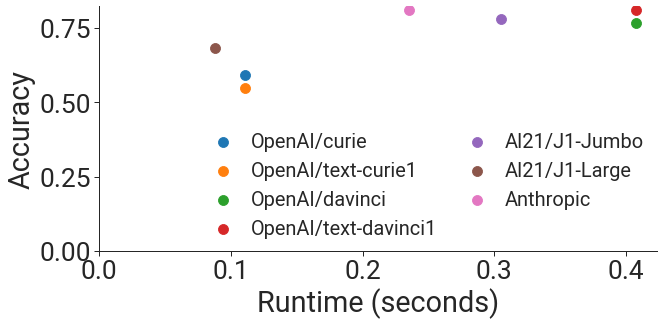

Scenario regex: imdb


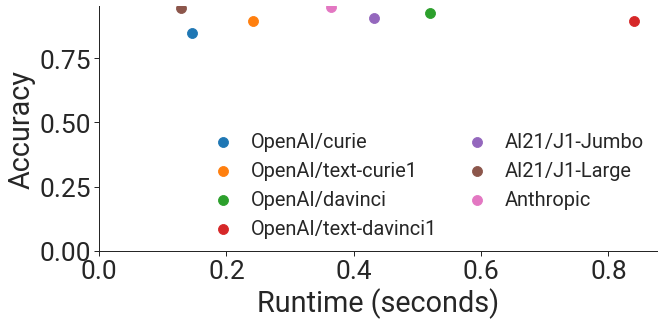

Scenario regex: news_qa


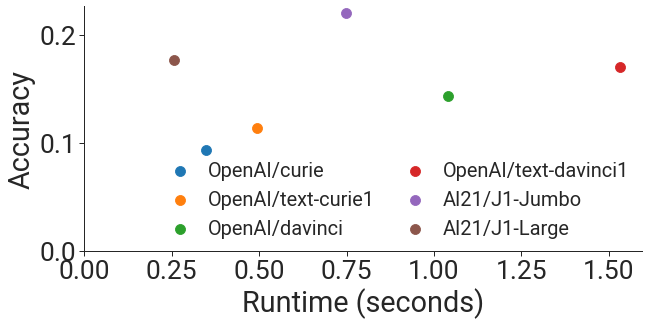

Scenario regex: mmlu,subject=philosophy


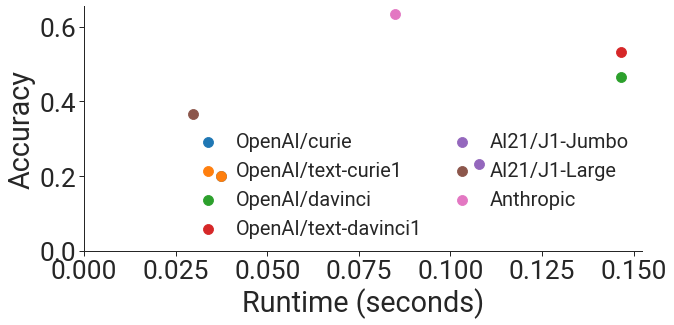

Scenario regex: natural_qa,mode=closedbook


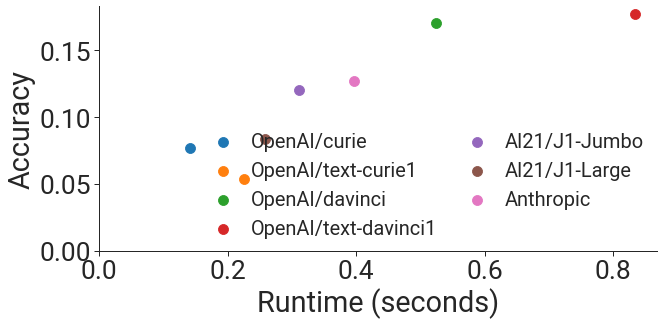

In [15]:
plot_metric1_versus_metric2(runtimes_dict, "inference_idealized_runtime",
                            "exact_match",
                            ["openai_curie", "openai_text-curie-001", "openai_davinci",
                             "openai_text-davinci-001", "ai21_j1-jumbo", "ai21_j1-large",
                             "anthropic_stanford-online-helpful-v4-s3"],
                            r'boolq',
                            ["OpenAI/curie", "OpenAI/text-curie1",
                             "OpenAI/davinci", "OpenAI/text-davinci1",
                             "AI21/J1-Jumbo", "AI21/J1-Large", "Anthropic"],
                            "Runtime (seconds)", "Accuracy")
plot_metric1_versus_metric2(runtimes_dict, "inference_idealized_runtime",
                            "exact_match",
                            ["openai_curie", "openai_text-curie-001", "openai_davinci",
                             "openai_text-davinci-001", "ai21_j1-jumbo", "ai21_j1-large",
                             "anthropic_stanford-online-helpful-v4-s3"],
                            r'imdb',
                            ["OpenAI/curie", "OpenAI/text-curie1",
                             "OpenAI/davinci", "OpenAI/text-davinci1",
                             "AI21/J1-Jumbo", "AI21/J1-Large", "Anthropic"],
                            "Runtime (seconds)", "Accuracy")
plot_metric1_versus_metric2(runtimes_dict, "inference_idealized_runtime",
                            "exact_match",
                            ["openai_curie", "openai_text-curie-001", "openai_davinci",
                             "openai_text-davinci-001", "ai21_j1-jumbo", "ai21_j1-large"],
                            r'news_qa',
                            ["OpenAI/curie", "OpenAI/text-curie1",
                             "OpenAI/davinci", "OpenAI/text-davinci1",
                             "AI21/J1-Jumbo", "AI21/J1-Large"],
                            "Runtime (seconds)", "Accuracy")
plot_metric1_versus_metric2(runtimes_dict, "inference_idealized_runtime",
                            "exact_match",
                            ["openai_curie", "openai_text-curie-001", "openai_davinci",
                             "openai_text-davinci-001", "ai21_j1-jumbo", "ai21_j1-large",
                             "anthropic_stanford-online-helpful-v4-s3"],
                            r'mmlu,subject=philosophy',
                            ["OpenAI/curie", "OpenAI/text-curie1",
                             "OpenAI/davinci", "OpenAI/text-davinci1",
                             "AI21/J1-Jumbo", "AI21/J1-Large", "Anthropic"],
                            "Runtime (seconds)", "Accuracy")
plot_metric1_versus_metric2(runtimes_dict, "inference_idealized_runtime",
                            "exact_match",
                            ["openai_curie", "openai_text-curie-001", "openai_davinci",
                             "openai_text-davinci-001", "ai21_j1-jumbo", "ai21_j1-large",
                             "anthropic_stanford-online-helpful-v4-s3"],
                            r'natural_qa,mode=closedbook',
                            ["OpenAI/curie", "OpenAI/text-curie1",
                             "OpenAI/davinci", "OpenAI/text-davinci1",
                             "AI21/J1-Jumbo", "AI21/J1-Large", "Anthropic"],
                            "Runtime (seconds)", "Accuracy")